<a href="https://colab.research.google.com/github/mairoky/privacy-frameworks/blob/main/data_privacy_frameworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install and Configure PySpark

In [58]:
# Install PySpark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark

# Set up environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

# Initialize PySpark
import findspark
findspark.init()

# Create a Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

print("It is Sparking!")


It is Sparking!


Load Dataset

In [59]:
# Download the Adult Census Income dataset
dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

# Use wget to download the data
!wget -q {dataset_url} -O adult.data

# Load the dataset into a Spark DataFrame
column_names = [
    "age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
    "occupation", "relationship", "race", "sex", "capital_gain",
    "capital_loss", "hours_per_week", "native_country", "income"
]

# Load dataset from the downloaded file
data = spark.read.csv('adult.data', header=False, inferSchema=True)
data = data.toDF(*column_names)  # Assign column names

# Show the first few rows
data.show(5)


+---+-----------------+--------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
|age|        workclass|  fnlwgt| education|education_num|     marital_status|        occupation|  relationship|  race|    sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+-----------------+--------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
| 39|        State-gov| 77516.0| Bachelors|         13.0|      Never-married|      Adm-clerical| Not-in-family| White|   Male|      2174.0|         0.0|          40.0| United-States| <=50K|
| 50| Self-emp-not-inc| 83311.0| Bachelors|         13.0| Married-civ-spouse|   Exec-managerial|       Husband| White|   Male|         0.0|         0.0|          13.0| United-States| <=50K|
| 38|          Private|215646.0|   HS-grad|       

Clean and Prepare the Data

In [60]:
# Drop rows with missing values
data = data.dropna()

# Convert categorical columns to numeric values using indexing
from pyspark.ml.feature import StringIndexer

categorical_cols = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country', 'income']

indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in categorical_cols]
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=indexers)
data = pipeline.fit(data).transform(data)

# Show processed data
data.show(5)


+---+-----------------+--------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+---------------+---------------+--------------------+----------------+------------------+----------+---------+--------------------+------------+
|age|        workclass|  fnlwgt| education|education_num|     marital_status|        occupation|  relationship|  race|    sex|capital_gain|capital_loss|hours_per_week|native_country|income|workclass_index|education_index|marital_status_index|occupation_index|relationship_index|race_index|sex_index|native_country_index|income_index|
+---+-----------------+--------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+---------------+---------------+--------------------+----------------+------------------+----------+---------+--------------------+------------

Data Privacy Frameworks Implementation

Implementing K-anonymity

In [61]:
from pyspark.sql.functions import round

# Generalize the 'age' column by rounding it to the nearest 10 (grouping similar ages)
data = data.withColumn('age_group', round(data['age'] / 10) * 10)

# Group by 'age_group' and 'education_num' to create anonymity groups
k_anonymized_data = data.groupBy('age_group', 'education_num').count()

# Show the anonymized dataset
k_anonymized_data.show(5)


+---------+-------------+-----+
|age_group|education_num|count|
+---------+-------------+-----+
|     40.0|          2.0|   32|
|     60.0|         15.0|   75|
|     40.0|         10.0| 1662|
|     80.0|          6.0|    8|
|     40.0|          4.0|   89|
+---------+-------------+-----+
only showing top 5 rows



In [62]:
# Group data by age group, workclass, and education level
k_anonymized_data = data.groupBy('age_group', 'workclass', 'education_num', 'hours_per_week', 'capital_gain', 'capital_loss', 'income').count()

# Show the anonymized dataset
k_anonymized_data.show(10)


+---------+-----------------+-------------+--------------+------------+------------+------+-----+
|age_group|        workclass|education_num|hours_per_week|capital_gain|capital_loss|income|count|
+---------+-----------------+-------------+--------------+------------+------------+------+-----+
|     30.0|          Private|          9.0|          40.0|         0.0|         0.0|  >50K|   76|
|     20.0|          Private|         13.0|          15.0|         0.0|         0.0| <=50K|    9|
|     30.0|     Self-emp-inc|         13.0|          50.0|      7688.0|         0.0|  >50K|    2|
|     40.0|          Private|         10.0|          48.0|         0.0|         0.0| <=50K|   14|
|     60.0|          Private|         12.0|          35.0|         0.0|         0.0|  >50K|    1|
|     50.0|      Federal-gov|         10.0|          40.0|      7688.0|         0.0|  >50K|    2|
|     40.0|          Private|         10.0|          42.0|         0.0|         0.0| <=50K|    5|
|     60.0| Self-emp

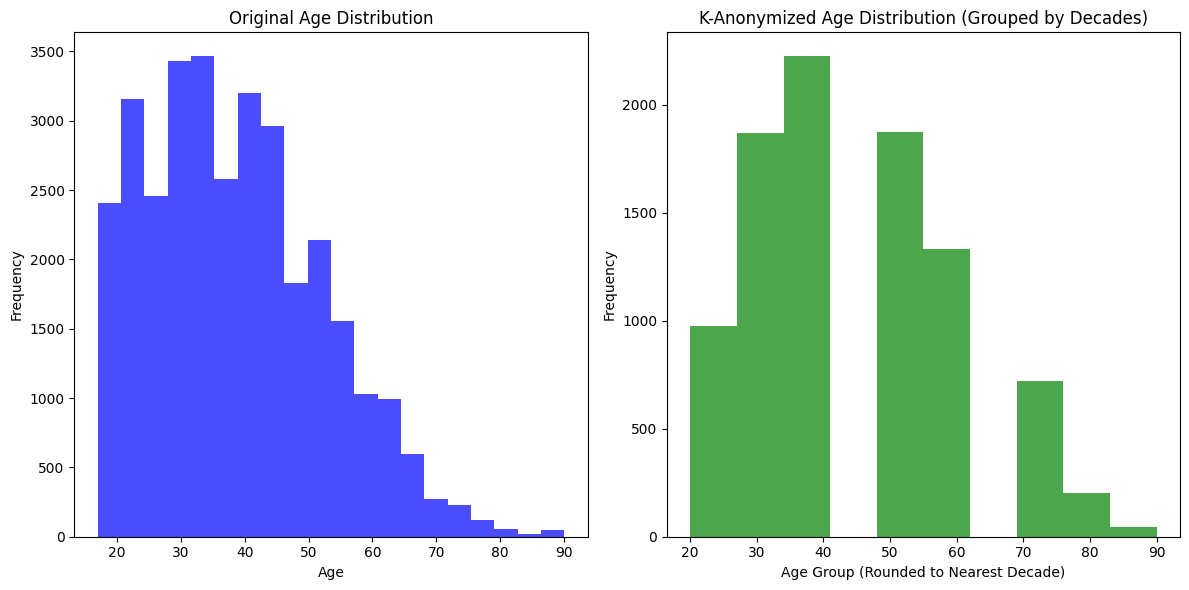

In [84]:
import matplotlib.pyplot as plt

# Extract the 'age' column from the original dataset
original_age = data.select('age').toPandas()

# Extract the 'age_group' column from the K-Anonymized dataset
k_anonymized_age = k_anonymized_data.select('age_group').toPandas()

# Plot the original vs K-Anonymized age distributions
plt.figure(figsize=(12, 6))

# Original Age Distribution
plt.subplot(1, 2, 1)
plt.hist(original_age['age'], bins=20, color='blue', alpha=0.7)
plt.title('Original Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

# K-Anonymized Age Distribution
plt.subplot(1, 2, 2)
plt.hist(k_anonymized_age['age_group'], bins=10, color='green', alpha=0.7)
plt.title('K-Anonymized Age Distribution (Grouped by Decades)')
plt.xlabel('Age Group (Rounded to Nearest Decade)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Implementing L-Diversity

In [63]:
from pyspark.sql.functions import col

# Filter out groups that do not satisfy K-anonymity (less than k members)
# Set the value of k (minimum group size)
k = 10
k_anonymized_data_filtered = k_anonymized_data.filter(col("count") >= k)

# Show the filtered anonymized data
k_anonymized_data_filtered.show(10)


+---------+----------+-------------+--------------+------------+------------+------+-----+
|age_group| workclass|education_num|hours_per_week|capital_gain|capital_loss|income|count|
+---------+----------+-------------+--------------+------------+------------+------+-----+
|     30.0|   Private|          9.0|          40.0|         0.0|         0.0|  >50K|   76|
|     40.0|   Private|         10.0|          48.0|         0.0|         0.0| <=50K|   14|
|     40.0|   Private|          9.0|          35.0|         0.0|         0.0| <=50K|   54|
|     50.0| Local-gov|         10.0|          40.0|         0.0|         0.0|  >50K|   13|
|     40.0|   Private|          6.0|          40.0|         0.0|         0.0| <=50K|   57|
|     40.0|   Private|         14.0|          50.0|         0.0|         0.0|  >50K|   34|
|     20.0|   Private|          7.0|          35.0|         0.0|         0.0| <=50K|   17|
|     60.0|   Private|          8.0|          40.0|         0.0|         0.0| <=50K|   14|

In [64]:
# Check the diversity of the 'income' attribute within each group
l_diversity_data = data.groupBy('age_group', 'workclass', 'hours_per_week', 'capital_gain', 'capital_loss', 'education_num', 'income').count()

# Show the groups with income diversity
l_diversity_data.show(10)


+---------+-------------+--------------+------------+------------+-------------+------+-----+
|age_group|    workclass|hours_per_week|capital_gain|capital_loss|education_num|income|count|
+---------+-------------+--------------+------------+------------+-------------+------+-----+
|     20.0|            ?|          32.0|     34095.0|         0.0|          6.0| <=50K|    1|
|     30.0|      Private|          64.0|         0.0|         0.0|         11.0| <=50K|    2|
|     50.0| Self-emp-inc|          55.0|         0.0|         0.0|         10.0|  >50K|    1|
|     70.0|      Private|          24.0|         0.0|         0.0|         11.0| <=50K|    1|
|     40.0|      Private|          40.0|         0.0|         0.0|          6.0| <=50K|   57|
|     40.0|  Federal-gov|          60.0|         0.0|         0.0|          9.0|  >50K|    1|
|     30.0|    State-gov|          20.0|         0.0|         0.0|         10.0| <=50K|    5|
|     40.0|      Private|          34.0|      3411.0|       

In [65]:
from pyspark.sql.functions import countDistinct

# Calculate the number of distinct income values in each group to ensure L-diversity
l_diversity_check = l_diversity_data.groupBy('age_group', 'workclass', 'education_num').agg(countDistinct('income').alias('income_diversity'))

# Set the value of l (minimum distinct income values required in each group)
l = 2

# Filter out groups that do not satisfy L-diversity (less than l distinct income values)
l_diversity_data_filtered = l_diversity_check.filter(col("income_diversity") >= l)

# Show the L-diverse data
l_diversity_data_filtered.show(10)


+---------+-------------+-------------+----------------+
|age_group|    workclass|education_num|income_diversity|
+---------+-------------+-------------+----------------+
|     40.0|  Federal-gov|          5.0|               2|
|     70.0|      Private|         13.0|               2|
|     20.0|    State-gov|         13.0|               2|
|     60.0| Self-emp-inc|         14.0|               2|
|     50.0|    Local-gov|         13.0|               2|
|     70.0|            ?|          6.0|               2|
|     40.0|            ?|          9.0|               2|
|     60.0|  Federal-gov|         10.0|               2|
|     50.0| Self-emp-inc|         16.0|               2|
|     30.0|      Private|          5.0|               2|
+---------+-------------+-------------+----------------+
only showing top 10 rows



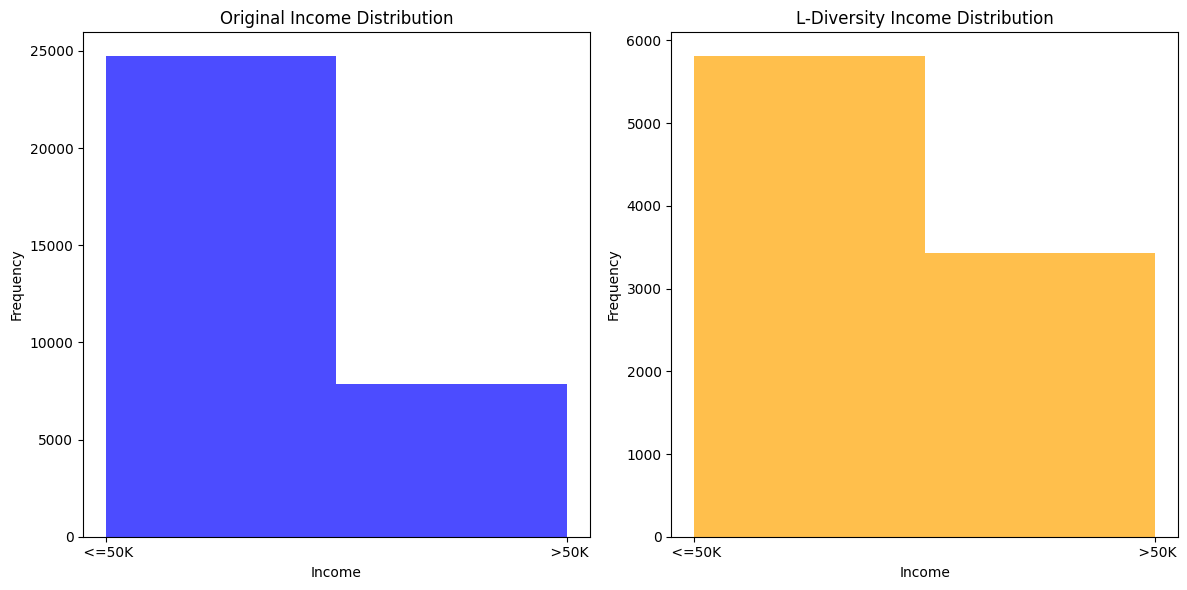

In [85]:
# Extract the 'income' column from the original dataset
original_income = data.select('income').toPandas()

# Extract the 'income' column from the L-Diversity dataset
l_diversity_income = l_diversity_data.select('income').toPandas()

# Plot the original vs L-Diversity income distributions
plt.figure(figsize=(12, 6))

# Original Income Distribution
plt.subplot(1, 2, 1)
plt.hist(original_income['income'], bins=2, color='blue', alpha=0.7)
plt.title('Original Income Distribution')
plt.xlabel('Income')
plt.ylabel('Frequency')

# L-Diversity Income Distribution
plt.subplot(1, 2, 2)
plt.hist(l_diversity_income['income'], bins=2, color='orange', alpha=0.7)
plt.title('L-Diversity Income Distribution')
plt.xlabel('Income')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Implementing T-Closeness

In [77]:
from pyspark.sql import Window
from pyspark.sql.functions import sum as spark_sum, abs as pyspark_abs, count

# Calculate the overall distribution of 'income'
total_records = data.count()
income_distribution = data.groupBy('income').count().withColumn('proportion', col('count') / total_records)
income_distribution.show()

# Group the data by 'age_group', 'workclass', 'education_num'
grouped_data = data.groupBy('age_group', 'workclass', 'education_num', 'income', 'hours_per_week', 'capital_gain', 'capital_loss').count()

# Calculate the distribution of 'income' within each group
window = Window.partitionBy('age_group', 'workclass', 'education_num')
grouped_data = grouped_data.withColumn('group_total', spark_sum('count').over(window))
grouped_data = grouped_data.withColumn('group_proportion', col('count') / col('group_total'))

# Compare the distribution in each group with the overall distribution
grouped_data = grouped_data.join(income_distribution, on='income')
grouped_data = grouped_data.withColumn('difference', pyspark_abs(col('group_proportion') - col('proportion'))) # Use the PySpark abs function

# Calculate the T-closeness for each group
grouped_data = grouped_data.groupBy('age_group', 'workclass', 'education_num', 'income', 'hours_per_week', 'capital_gain', 'capital_loss').agg(spark_sum('difference').alias('t_closeness'))

# Filter groups that satisfy the T-closeness constraint
t_threshold = 0.2  # Define the T threshold (this can be adjusted)
t_closeness_data = grouped_data.filter(col('t_closeness') <= t_threshold)

# Show the T-closeness compliant groups
t_closeness_data.show(10)

+------+-----+------------------+
|income|count|        proportion|
+------+-----+------------------+
|  >50K| 7841|0.2408095574460244|
| <=50K|24720|0.7591904425539756|
+------+-----+------------------+

+---------+-----------------+-------------+------+--------------+------------+------------+--------------------+
|age_group|        workclass|education_num|income|hours_per_week|capital_gain|capital_loss|         t_closeness|
+---------+-----------------+-------------+------+--------------+------------+------------+--------------------+
|     60.0|          Private|         15.0|  >50K|          40.0|         0.0|      1902.0| 0.15385303570689396|
|     30.0|     Self-emp-inc|         15.0|  >50K|          40.0|     15024.0|         0.0| 0.09252377588730892|
|     60.0|          Private|         16.0|  >50K|          50.0|         0.0|         0.0| 0.09795241458888154|
|     40.0|        State-gov|         11.0|  >50K|          40.0|      8614.0|         0.0|  0.1783095574460244|
|   

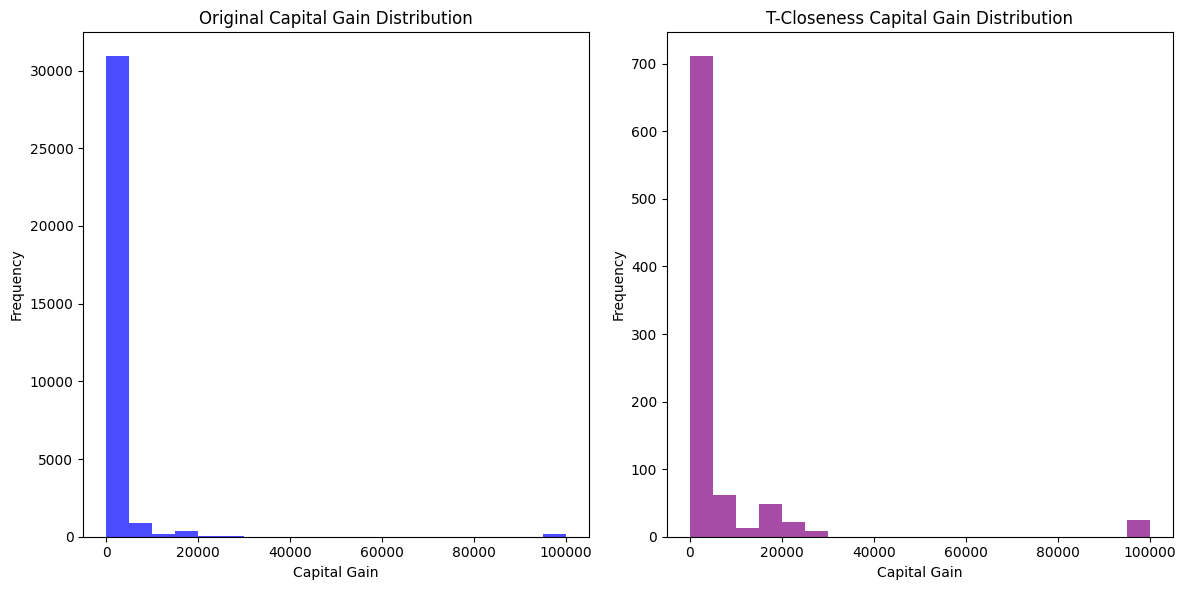

In [86]:
# Extract 'capital_gain' from the original dataset
original_capital_gain = data.select('capital_gain').toPandas()

# Extract 'capital_gain' from the T-Closeness dataset
t_closeness_capital_gain = t_closeness_data.select('capital_gain').toPandas()

# Plot the original vs T-Closeness capital gain distributions
plt.figure(figsize=(12, 6))

# Original Capital Gain Distribution
plt.subplot(1, 2, 1)
plt.hist(original_capital_gain['capital_gain'], bins=20, color='blue', alpha=0.7)
plt.title('Original Capital Gain Distribution')
plt.xlabel('Capital Gain')
plt.ylabel('Frequency')

# T-Closeness Capital Gain Distribution
plt.subplot(1, 2, 2)
plt.hist(t_closeness_capital_gain['capital_gain'], bins=20, color='purple', alpha=0.7)
plt.title('T-Closeness Capital Gain Distribution')
plt.xlabel('Capital Gain')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Implementing Differential Privacy

In [67]:
import numpy as np
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

# Function to add Laplace noise for differential privacy
def add_noise(value, epsilon):
    sensitivity = 1.0  # Define the sensitivity of the data (e.g., age has a sensitivity of 1)
    noise = np.random.laplace(0, sensitivity / epsilon)  # Generate Laplace noise
    return float(value + noise)

# Create a UDF to apply the noise function to the age column
epsilon = 0.5  # Set the privacy budget
add_noise_udf = udf(lambda x: add_noise(x, epsilon), FloatType())

# Apply noise to the 'age' column
data_with_dp = data.withColumn('age_dp', add_noise_udf('age'))

# Show the noisy dataset
data_with_dp.select('age', 'age_dp').show(10)


+---+---------+
|age|   age_dp|
+---+---------+
| 39|36.878532|
| 50| 50.53461|
| 38|38.469536|
| 53|53.861103|
| 28|29.196815|
| 37| 40.23164|
| 49|47.583878|
| 52| 50.78993|
| 31| 29.00346|
| 42|40.616276|
+---+---------+
only showing top 10 rows



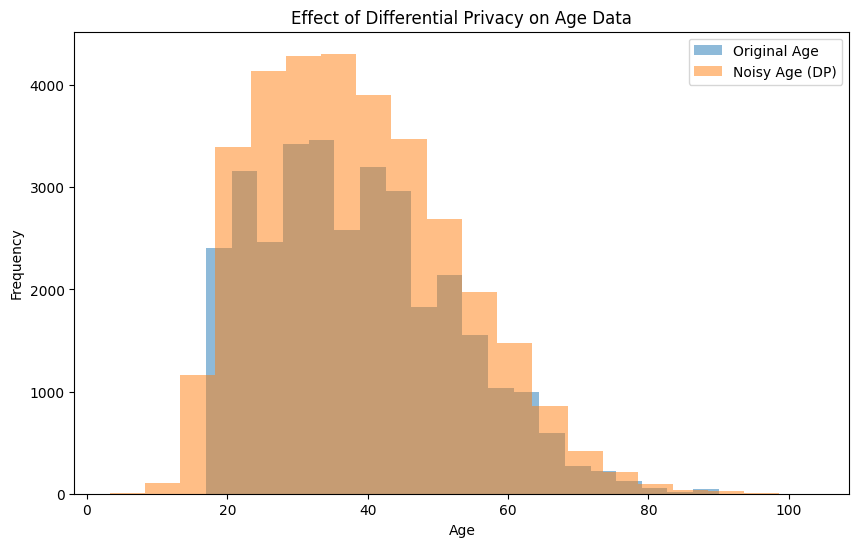

In [68]:
import matplotlib.pyplot as plt

# Convert the data to Pandas for easier plotting
df_pandas = data_with_dp.select('age', 'age_dp').toPandas()

# Plot the original and noisy age columns
plt.figure(figsize=(10, 6))
plt.hist(df_pandas['age'], bins=20, alpha=0.5, label='Original Age')
plt.hist(df_pandas['age_dp'], bins=20, alpha=0.5, label='Noisy Age (DP)')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Effect of Differential Privacy on Age Data')
plt.legend()
plt.show()


Implementing Federated Learning

In [69]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import DataFrame

# Prepare the data (assemble features)
feature_columns = ['age', 'education_num', 'hours_per_week', 'capital_gain', 'capital_loss']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
data = assembler.transform(data)

# Split the data into 3 partitions (simulating 3 clients)
client_data = data.randomSplit([0.33, 0.33, 0.34])

# Function to train a model on each client
def train_local_model(client_df: DataFrame):
    # Logistic Regression Model
    lr = LogisticRegression(featuresCol='features', labelCol='income_index')  # Assuming 'income_index' is binary
    local_model = lr.fit(client_df)
    return local_model

# Train a local model on each client
local_models = [train_local_model(client_df) for client_df in client_data]

# Aggregate the local model coefficients (simulate federated aggregation)
global_coefficients = sum([model.coefficients for model in local_models]) / len(local_models)
global_intercept = sum([model.intercept for model in local_models]) / len(local_models)

# Create a global model using the aggregated coefficients and intercept
global_model = LogisticRegression(featuresCol='features', labelCol='income_index')
global_model.coefficients = global_coefficients
global_model.intercept = global_intercept

# Show global model coefficients
print("Global model coefficients:", global_coefficients)
print("Global model intercept:", global_intercept)


Global model coefficients: [0.04306729153473953,0.3230421297493064,0.040817795190267465,0.0003188363027976523,0.0006986680601821227]
Global model intercept: -8.325238888005401


In [70]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Use one of the client datasets as the test set
test_data = client_data[2]  # Third client’s data as the test set

# Fit the global model before using it to make predictions
global_model = global_model.fit(data) # Fit the global model to the entire dataset

# Evaluate the global model on the test data
predictions = global_model.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol='income_index', rawPredictionCol='prediction')

accuracy = evaluator.evaluate(predictions)
print(f"Global Model Accuracy: {accuracy}")


Global Model Accuracy: 0.667963468690584


Secure Multi-Party Computation (SMPC)

In [71]:
import random

# Step 1: Function to generate shares of a secret
def generate_shares(secret, num_shares):
    shares = [random.randint(0, 100) for _ in range(num_shares - 1)]  # Generate random shares
    last_share = secret - sum(shares)  # Ensure the sum of shares equals the original secret
    shares.append(last_share)
    return shares

# Step 2: Each party holds a share of the secret (e.g., income)
secret_value = 50000  # Example income value
num_parties = 3

shares = generate_shares(secret_value, num_parties)
print(f"Original Secret: {secret_value}")
print(f"Shares: {shares}")

# Step 3: Each party holds their share and computes their part (e.g., sum in this case)
def party_computation(share):
    return share  # In real SMPC, more complex operations would be done on the shares

# Step 4: Each party computes its own part
party_results = [party_computation(share) for share in shares]

# Step 5: Combine the results to get the final computation (sum in this case)
final_result = sum(party_results)
print(f"Final result after SMPC: {final_result}")


Original Secret: 50000
Shares: [80, 68, 49852]
Final result after SMPC: 50000


Evaluating the Privacy Frameworks

In [81]:
from pyspark.ml.feature import StringIndexer

# Index the 'income' column to create 'income_index' (0 for <=50K, 1 for >50K)
indexer = StringIndexer(inputCol='income', outputCol='income_index')
l_diversity_data = indexer.fit(l_diversity_data).transform(l_diversity_data)
t_closeness_data = indexer.fit(t_closeness_data).transform(t_closeness_data)

k_anonymized_data.printSchema()
k_anonymized_data.show(5)

l_diversity_data.printSchema()
l_diversity_data.show(5)

t_closeness_data.printSchema()
t_closeness_data.show(5)

data_with_dp.printSchema()
data_with_dp.show(5)

root
 |-- age_group: double (nullable = true)
 |-- workclass: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- income: string (nullable = true)
 |-- count: long (nullable = false)
 |-- income_index: double (nullable = false)
 |-- features: vector (nullable = true)

+---------+-------------+-------------+--------------+------------+------------+------+-----+------------+--------------------+
|age_group|    workclass|education_num|hours_per_week|capital_gain|capital_loss|income|count|income_index|            features|
+---------+-------------+-------------+--------------+------------+------------+------+-----+------------+--------------------+
|     30.0|      Private|          9.0|          40.0|         0.0|         0.0|  >50K|   76|         1.0|[30.0,9.0,40.0,0....|
|     20.0|      Private|         13.0|          15.0|        

In [82]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Define the feature columns
feature_columns = ['age_group', 'education_num', 'hours_per_week', 'capital_gain', 'capital_loss']

# Assemble the features for the original dataset and all privacy-enhanced datasets
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Example data preparation for each privacy-enhanced dataset:
# Check if 'features' column already exists and drop if it does
if 'features' in k_anonymized_data.columns:
    k_anonymized_data = k_anonymized_data.drop('features')
k_anonymized_data = assembler.transform(k_anonymized_data)  # K-Anonymity

if 'features' in l_diversity_data.columns:
    l_diversity_data = l_diversity_data.drop('features')
l_diversity_data = assembler.transform(l_diversity_data)  # L-Diversity

if 'features' in t_closeness_data.columns:
    t_closeness_data = t_closeness_data.drop('features')
t_closeness_data = assembler.transform(t_closeness_data)  # T-Closeness

if 'features' in data_with_dp.columns:
    data_with_dp = data_with_dp.drop('features')
data_with_dp = assembler.transform(data_with_dp)  # Differential Privacy

# Initialize Binary Classification Evaluator
evaluator = BinaryClassificationEvaluator(labelCol='income_index', rawPredictionCol='rawPrediction')

# Original Data
train_data, test_data = data.randomSplit([0.8, 0.2])
lr = LogisticRegression(featuresCol='features', labelCol='income_index')
model = lr.fit(train_data)
predictions = model.transform(test_data)
accuracy = evaluator.evaluate(predictions)
print(f"Model Accuracy on Original Data: {accuracy}")

# K-Anonymity Enhanced Data
train_data_k, test_data_k = k_anonymized_data.randomSplit([0.8, 0.2])
lr_k = LogisticRegression(featuresCol='features', labelCol='income_index')
model_k = lr_k.fit(train_data_k)
predictions_k = model_k.transform(test_data_k)
accuracy_k = evaluator.evaluate(predictions_k)
print(f"Model Accuracy on K-Anonymized Data: {accuracy_k}")

# L-Diversity Enhanced Data
train_data_l, test_data_l = l_diversity_data.randomSplit([0.8, 0.2])
lr_l = LogisticRegression(featuresCol='features', labelCol='income_index')
model_l = lr_l.fit(train_data_l)
predictions_l = model_l.transform(test_data_l)
accuracy_l = evaluator.evaluate(predictions_l)
print(f"Model Accuracy on L-Diversity Data: {accuracy_l}")

# T-Closeness Enhanced Data
train_data_t, test_data_t = t_closeness_data.randomSplit([0.8, 0.2])
lr_t = LogisticRegression(featuresCol='features', labelCol='income_index')
model_t = lr_t.fit(train_data_t)
predictions_t = model_t.transform(test_data_t)
accuracy_t = evaluator.evaluate(predictions_t)
print(f"Model Accuracy on T-Closeness Data: {accuracy_t}")

# Differential Privacy Enhanced Data
train_data_dp, test_data_dp = data_with_dp.randomSplit([0.8, 0.2])
lr_dp = LogisticRegression(featuresCol='features', labelCol='income_index')
model_dp = lr_dp.fit(train_data_dp)
predictions_dp = model_dp.transform(test_data_dp)
accuracy_dp = evaluator.evaluate(predictions_dp)
print(f"Model Accuracy on Differential Privacy Data: {accuracy_dp}")


Model Accuracy on Original Data: 0.8385163319855334
Model Accuracy on K-Anonymized Data: 0.8186486923097024
Model Accuracy on L-Diversity Data: 0.8175265725810897
Model Accuracy on T-Closeness Data: 0.9697802197802198
Model Accuracy on Differential Privacy Data: 0.8370449425304779


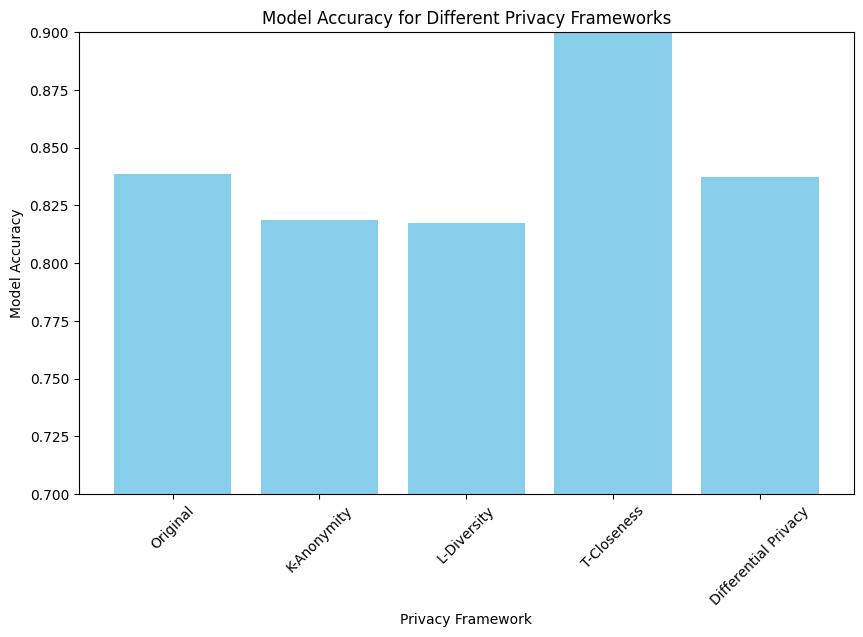

In [83]:
import matplotlib.pyplot as plt

# Store all accuracy results (replace with your actual results from above)
frameworks = ['Original', 'K-Anonymity', 'L-Diversity', 'T-Closeness', 'Differential Privacy']
accuracies = [accuracy, accuracy_k, accuracy_l, accuracy_t, accuracy_dp]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(frameworks, accuracies, color='skyblue')
plt.xlabel('Privacy Framework')
plt.ylabel('Model Accuracy')
plt.title('Model Accuracy for Different Privacy Frameworks')
plt.ylim([0.7, 0.9])  # Adjust limits based on actual results
plt.xticks(rotation=45)
plt.show()
